# core

> lisette core

In [ ]:
#| default_exp core

In [ ]:
#| export
import litellm, json
from litellm import completion, stream_chunk_builder
from litellm.types.utils import ModelResponseStream,ModelResponse
from litellm.utils import function_to_dict
from toolslm.funccall import mk_ns, call_func
from toolslm.funccall import get_schema
from typing import Optional
from fastcore.all import *

## LiteLLM

Litellm provides an easy wrapper for most big LLM providers.

In [ ]:
ms = ["gemini/gemini-2.5-flash", "claude-sonnet-4-20250514", "openai/gpt-4.1"]

TODO: test mixed content/tool calls message (and mixed images too).

In [ ]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if message.content: content += message.content
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {tc.function.name}({tc.function.arguments})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    if not content: content = str(message)
    details = [
        f"id: `{self.id}`",
        f"model: `{self.model}`",
        f"finish_reason: `{self.choices[0].finish_reason}`"
    ]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    
    return f"""{content}

<details>

- {det_str}

</details>"""

In [ ]:
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]

In [ ]:
for m in ms:
    display(f'=== {m} ===')
    display(completion(m,msg))

### Streaming

In [ ]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [ ]:
from fastcore.xtras import SaveReturn

In [ ]:
model = ms[1]

In [ ]:
r = completion(messages=msg, model=model, stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [ ]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hello! Nice to meet you! How are you doing today?

In [ ]:
r2.value

Hello! Nice to meet you! How are you doing today?

<details>

- id: `chatcmpl-31c97548-50c6-443f-94ea-2b7cf94f54e1`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=16, prompt_tokens=0, total_tokens=16, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

### Tools

In [ ]:
#| export
def _lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [ ]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    print(f"TOOL CALLED {a=} + {b=}")
    return a + b

In [ ]:
toolsc = _lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [ ]:
#| export
def mk_user(s, cache=False):
    res = {"role": "user", "content": s}
    if cache: res['cache_control'] = {'type': 'ephemeral'}
    return res

In [ ]:
tmsg = mk_user("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible.")
r = completion(model, [tmsg], tools=[toolsc])

In [ ]:
r

I'll help you calculate both of those addition problems using the simple_add tool. Let me perform both calculations for you:

1. First, I'll calculate 5478954793 + 547982745
2. Then, I'll calculate 5479749754 + 9875438979

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-7f609a10-8215-465d-9525-d0638f518978`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=199, prompt_tokens=475, total_tokens=674, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
#| export
def _lite_call_func(tc,ns,raise_on_err=True):
    res = call_func(tc.function.name, json.loads(tc.function.arguments),ns=ns)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": str(res)}

In [ ]:
tcs = [_lite_call_func(o, ns=globals()) for o in r.choices[0].message.tool_calls]
tcs

TOOL CALLED a=5478954793 + b=547982745
TOOL CALLED a=5479749754 + b=9875438979


[{'tool_call_id': 'toolu_01TNC8CtoYUJrqipnG5zBYGd',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'toolu_01STPhKH6PErNvvVM3cu5BCv',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [ ]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [ ]:
r = completion(messages=[tmsg], model=model, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I'll help you calculate both of those sums using

 the addition tool. Let me perform both calculations for you:

1

. First, I'll calculate 5478954793 + 547982745
2. Then, I'll calculate 5479749754 + 9

875438979
🔧 simple_add


🔧 simple_add

In [ ]:
r2.value

I'll help you calculate both of those sums using the addition tool. Let me perform both calculations for you:

1. First, I'll calculate 5478954793 + 547982745
2. Then, I'll calculate 5479749754 + 9875438979

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-db44a956-6eed-4964-8c04-287b90977676`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=197, prompt_tokens=0, total_tokens=197, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
msg = mk_user("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = completion(messages=[msg], model=model, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')


🧠🧠🧠

🧠🧠🧠

🧠🧠🧠🧠🧠

🧠🧠

🧠🧠

🧠🧠🧠

🧠🧠🧠

🧠🧠🧠

🧠🧠

I'll find the derivative of f(x) = x³ + 2

x² - 5x + 1 using the power rule.

**Step-by-step solution

:**

Using the power rule: if f(x) = xⁿ, then f'(x) = nx

ⁿ⁻¹

For each term:
- d/dx(x³) = 

3x²
- d/dx(2x²) = 2 × 2x¹ = 4x  
- d/dx(-5x

) = -5 × 1x⁰ = -5
- d/dx(1) = 0 

(derivative of a constant)



**Therefore:**
f'(x) = 3x² + 4x - 5

The derivative is **3x² + 4x - 

5**.

In [ ]:
r2.value

I'll find the derivative of f(x) = x³ + 2x² - 5x + 1 using the power rule.

**Step-by-step solution:**

Using the power rule: if f(x) = xⁿ, then f'(x) = nxⁿ⁻¹

For each term:
- d/dx(x³) = 3x²
- d/dx(2x²) = 2 × 2x¹ = 4x  
- d/dx(-5x) = -5 × 1x⁰ = -5
- d/dx(1) = 0 (derivative of a constant)

**Therefore:**
f'(x) = 3x² + 4x - 5

The derivative is **3x² + 4x - 5**.

<details>

- id: `chatcmpl-641f930d-b5c9-449c-9539-ac86fb68d649`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=407, prompt_tokens=0, total_tokens=407, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=176, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
search_tool = { "type": "web_search_20250305", "name": "web_search", "max_uses": 3}
smsg = mk_user("Search the web and tell me very briefly about otters")
r = completion(ms[1], [smsg], tools=[search_tool])
r

There are 13 different otter species worldwide, with the U.S. home to two species: the sea otter and the North American river otter.

Otters are distinguished by their long, slim bodies, powerful webbed feet for swimming, and their dense fur, which keeps them warm and buoyant in water. They are playful animals, engaging in activities like sliding into water on natural slides and playing with stones.

Otters are carnivorous mammals in the subfamily Lutrinae, which is a branch of the Mustelidae family that includes weasels, badgers, and wolverines. The 13 species range in adult size from 0.6 to 1.8 m (2.0 to 5.9 ft) in length and 1 to 45 kg (2.2 to 99.2 lb) in weight.

Sea otters have the densest fur of any animal on earth with an estimated 1 million hairs per square inch, while river otters are much smaller — averaging 10-30 pounds — with sea otters weighing around 45-90 pounds. Otters can stay underwater for eight minutes and swim up to seven miles per hour.

Sea otters are one of the only marine mammals that uses tools, using rocks to crack open their favorite foods. Sea otters are considered a keystone species, helping keep sea urchin populations in control, which ensures kelp forests are not overgrazed.

<details>

- id: `chatcmpl-07ba79fc-ca89-4a5d-8348-26d743ff7e95`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=583, prompt_tokens=13879, total_tokens=14462, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), server_tool_use=ServerToolUse(web_search_requests=1), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

When not using streaming, all citations are placed in a separate key in the response:

In [ ]:
r.choices[0].message.provider_specific_fields['citations'][0]

[{'type': 'web_search_result_location',
  'cited_text': 'Thirteen different species exist around the globe. ',
  'url': 'https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week',
  'title': '12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior',
  'encrypted_index': 'Eo8BCioIBRgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDLxB6qhtyIaC79Y7PBoMwfl4casuryrnkhSPIjD4eRCWK8r0BYWkByat3HD0TC5+dhXbz8tIHVg0P0odTiiph8xxJi5J8gdRUYal2y8qExH74qCzXg+0ZXjN+Kl/asDrf4kYBA=='}]

In [ ]:
r = list(completion(ms[1], [smsg], tools=[search_tool], stream=True))

In [ ]:
#| export
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list:
        delta = nested_idx(msg, 'choices', 0, 'delta')
        if not delta: continue
        citation = nested_idx(delta, 'provider_specific_fields', 'citation')
        if citation:
            title = citation['title'].replace('"', '\\"')
            delta.content = f'[*]({citation["url"]} "{title}") '

In [ ]:
cite_footnotes(r)
stream_chunk_builder(r)

Otters are fascinating aquatic mammals! Here are the key facts:

[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are carnivorous mammals in the subfamily Lutrinae, with 13 extant species that are all semiaquatic, aquatic, or marine. [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") They belong to the Mustelidae family, which includes weasels, badgers, mink, and wolverines.

**Physical Features:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are distinguished by their long, slim bodies, powerful webbed feet for swimming, and their dense fur, which keeps them warm and buoyant in water. [*](https://oceana.ca/en/blog/10-amazing-facts-about-sea-otters/ "10 Amazing Facts about Sea otters! Learn more - Oceana Canada") Sea otters have the densest fur of any animal on earth with an estimated 1 million hairs per square inch.

**Behavior:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") They are playful animals, engaging in activities like sliding into water on natural slides and playing with stones. [*](https://www.nationalforests.org/blog/seven-quick-facts-about-river-otters "Seven Quick Facts About River Otters - National Forest Foundation") In the winter, otters have found the easiest and perhaps most fun way to get around is by sliding, and after a few bumps, they can slide up to 22 feet on the ice.

**Abilities:** [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") River otters can hold their breath for up to 8 minutes. [*](https://www.nationalforests.org/blog/seven-quick-facts-about-river-otters "Seven Quick Facts About River Otters - National Forest Foundation") Otters can swim up to seven miles per hour and dive down 60 feet. [*](https://oceana.ca/en/blog/10-amazing-facts-about-sea-otters/ "10 Amazing Facts about Sea otters! Learn more - Oceana Canada") Sea otters are one of the only marine mammals that uses tools, using rocks to crack open shellfish.

**Diet and Habitat:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Their usual source of food is fish, and further downriver, eels, but they may sample frogs and birds. [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") The 13 species range in adult size from 0.6 to 1.8 m in length and 1 to 45 kg in weight, with the Asian small-clawed otter being the smallest and the giant otter and sea otter being the largest.

<details>

- id: `chatcmpl-73252916-33ac-49fb-9994-96c2170b27fa`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=619, prompt_tokens=13695, total_tokens=14314, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

## Chat

Litellm is pretty bare bones. It doesnt keep track of conversation history or anything.

So lets make a claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [ ]:
#| export
class Chat:
    def __init__(self, model:str, sp='', temp=0, tools:list=None, hist:list=None, ns:Optional[dict]=None, cache=False):
        "LiteLLM chat client."
        self.model = model
        hist,tools = listify(hist),listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [_lite_mk_func(t) for t in tools] if tools else None
        store_attr()
    
    def _prepare_msgs(self, msg=None):
        "Prepare the messages list for the API call"
        msgs = [{"role": "system", "content": self.sp}] if self.sp else []
        self.hist += [mk_user(msg, cache=self.cache)] if isinstance(msg, str) \
            else [msg] if isinstance(msg, dict) \
            else [] if msg is None \
            else msg
        return msgs + [m if isinstance(m, dict) else m.model_dump() for m in self.hist]

    def _call(self, msg=None, stream=False, max_tool_rounds=1, tool_round=0, final_prompt=None, tool_choice=None, **kwargs):
        "Internal method that always yields responses"
        msgs = self._prepare_msgs(msg)
        res = completion(model=self.model, messages=msgs, stream=stream, 
                         tools=self.tool_schemas, temperature=self.temp, **kwargs)
        if stream: res = yield from stream_with_complete(res, postproc=cite_footnotes)
        m = res.choices[0].message
        self.hist.append(m)
        yield res

        if tcs := m.tool_calls:
            tool_results = [_lite_call_func(tc, ns=self.ns) for tc in tcs]
            if tool_round>=max_tool_rounds-1:
                tool_results += ([{"role": "user", "content": final_prompt}] if final_prompt else [])
                tool_choice='none'
            yield from self._call(
                tool_results, stream, max_tool_rounds, tool_round+1,
                final_prompt, tool_choice=tool_choice, **kwargs)
    
    def __call__(self, msg=None, stream=False, max_tool_rounds=1,
                 final_prompt=None, return_all=False, **kwargs):
        "Main call method - handles streaming vs non-streaming"
        result_gen = self._call(msg, stream, max_tool_rounds, 0, final_prompt, **kwargs)     
        if stream: return result_gen              # streaming
        elif return_all: return list(result_gen)  # toolloop behavior
        else: return last(result_gen)             # normal chat behavior

### Test history tracking

In [ ]:
chat = Chat(m)
res = chat("Hey my name is Rens")
res

Hi Rens! Nice to meet you. How can I help you today? 😊

<details>

- id: `chatcmpl-Bw0PFeoINzP5ECTVEkHrTViHkZIuO`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=13, total_tokens=30, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
chat("Whats my name")

Your name is Rens!

<details>

- id: `chatcmpl-Bw02hC1bb1juO1O0JCmJRIVyRt8sW`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=6, prompt_tokens=41, total_tokens=47, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See now we keep track of history!

### Testing streaming

In [ ]:
from time import sleep
chat2 = Chat(m)
stream_gen = chat2("Count to 5", stream=True)
for chunk in stream_gen:
    sleep(0.1)  # for effect
    if isinstance(chunk, ModelResponse): display(chunk)
    else: print(delta_text(chunk) or '',end='')

## Test tool use

Ok now lets test tool use

In [ ]:
for m in ms:
    display(f'=== {m} ===')
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3?")
    display(res)

In [ ]:
chat = Chat(ms[1], tools=[search_tool])
res = chat("Search the web and tell me very briefly about otters", stream=True)
for o in res:
    if isinstance(o, ModelResponse): sleep(0.01); display(o)
    else: print(delta_text(o) or '',end='')

## Test multi tool calling

In [ ]:
chat = Chat(model, tools=[simple_add])
res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_tool_rounds=5)
for r in res: display(r)

TOOL CALLED a=5 + b=3
TOOL CALLED a=8 + b=7
TOOL CALLED a=15 + b=11


I'll solve this step by step using the addition function.

First, let me calculate 5 + 3:

🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-226fd536-b757-4990-8ac4-45333928e431`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=96, prompt_tokens=434, total_tokens=530, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Now I'll add 7 to that result (8 + 7):

🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-db2a71fc-f6d2-47e0-b73a-9eb2b5f26d6f`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=88, prompt_tokens=543, total_tokens=631, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Finally, I'll add 11 to that result (15 + 11):

🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-a2b0069e-1aa5-4558-a88c-c737f3b5b025`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=89, prompt_tokens=644, total_tokens=733, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

So working step by step:
- 5 + 3 = 8
- 8 + 7 = 15  
- 15 + 11 = 26

Therefore, ((5 + 3) + 7) + 11 = **26**

<details>

- id: `chatcmpl-5bc6e20b-0f4a-49dd-b161-e4e54db6f31d`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=68, prompt_tokens=746, total_tokens=814, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [ ]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    print(f"MULTIPLY: {a} * {b}")
    return a * b

chat = Chat(ms[-1], tools=[simple_add, multiply])
res = chat("Calculate (5 + 3) * (7 + 2)", max_tool_rounds=5, return_all=True)
for r in res: display(r)

TOOL CALLED a=5 + b=3
TOOL CALLED a=7 + b=2
MULTIPLY: 8 * 9




🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-Bvdtiy7zTv7EH5MWjV2Zf584QF8Ns`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-Bvdtjs2e1szA0uQVyW1zHxXdPnzlf`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

(5 + 3) = 8 and (7 + 2) = 9. Multiplying them together: 8 × 9 = 72.

So, (5 + 3) × (7 + 2) = 72.

<details>

- id: `chatcmpl-BvdtjudM6i6WJwHywkDYvLfGNyVeu`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=54, prompt_tokens=203, total_tokens=257, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See it did the additions in one go!

Hit max_tool_rounds limit with final_prompt

In [ ]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    display(f"DIVIDE: {a} / {b}")
    return a / b

chat = Chat(m, tools=[simple_add, multiply, divide])
res = chat("Calculate ((10 + 5) * 3) / (2 + 1) step by step", 
           max_tool_rounds=2, return_all=True,
           final_prompt="Please summarize what you've calculated so far")
print(f"Got {len(res)} responses")
for r in res: display(r)

TOOL CALLED a=10 + b=5
MULTIPLY: 15 * 3
Got 3 responses




🔧 simple_add({"a":10,"b":5})


<details>

- id: `chatcmpl-BvdtkErTK2l94Cf5C7o47aj5RHWyL`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=146, total_tokens=164, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>



🔧 multiply({"a":15,"b":3})


<details>

- id: `chatcmpl-BvdtlxEeR26kOp6xlSiwMKyru0nHM`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=173, total_tokens=190, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Here’s what I’ve calculated so far, step by step:

1. First, I added 10 + 5 to get 15.
2. Next, I multiplied the result (15) by 3 to get 45.

So, ((10 + 5) * 3) = 45.

The next step is to calculate the denominator (2 + 1) and then divide 45 by that result. Would you like me to continue?

<details>

- id: `chatcmpl-BvdtmXBxPxvUYlkOvx3CQgO7lPtb5`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=95, prompt_tokens=209, total_tokens=304, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

## Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
from IPython.display import Image

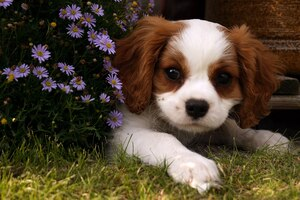

In [ ]:
fn = Path('samples/puppy.jpg')
Image(filename=fn, width=200)

In [ ]:
def _mk_img(data:bytes)->tuple:
    "Convert image bytes to a base64 encoded image"
    img = base64.b64encode(data).decode("utf-8")
    mtype = mimetypes.types_map["."+imghdr.what(None, h=data)]
    return img, mtype

In [ ]:
import base64
import mimetypes
from fastcore import imghdr

In [ ]:
imgbytes = fn.read_bytes()
img,mtype = _mk_img(imgbytes)
imgd = { "image_url": {"url": f'data:{mtype};base64,{img}', "format":mtype} }

In [ ]:
response = completion( model=model, 
    messages=[
        { "role": "user",
        "content": [{ "type": "text", "text": "What’s in this image?" },
        { "type": "image_url", **imgd }] }
    ])

In [ ]:
response

This image shows an adorable puppy, likely a Cavalier King Charles Spaniel or similar breed, with distinctive brown and white fur markings. The puppy has beautiful brown patches around its ears and eyes, with a white face and chest. It's lying on green grass next to some purple flowers (which appear to be small daisies or asters). The puppy has a sweet, gentle expression with dark eyes and appears to be very young. The setting looks like a garden or yard area with natural lighting that highlights the puppy's soft, fluffy coat.

<details>

- id: `chatcmpl-834cbca3-7ed9-4506-a467-0f93f555d987`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=122, prompt_tokens=104, total_tokens=226, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>